In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import pickle

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

%matplotlib inline

In [2]:
fp = open("./lightcurves/tesslc_364539361.pkl","rb")
data = pickle.load(fp)
fp.close()

In [3]:
def cutLightCurve(times, lc, t0, t1):
    floor = False
    ceil = False
    med = np.median(lc)
    for i in times:
        if i > t0 and floor == False:
            floor = i
        if i > t1 and ceil == False:
            ceil = i
    if ceil == False:
        ceil = times[len(times)-1]
    dif = times[1]-times[0]
    newTimes = np.arange(floor,ceil+dif,dif)
    newLc = []
    
    for i in range(len(times)):
        if times[i] > t0 and times[i] < t1:
            exist = False
            for j in newTimes:
                if times[i] == j:
                    exist = True
            if exist == True:
                newLc.append(lc[i])
            elif exist == False:
                times.itemset(i, 0)
                lc.itemset(i,med)
                newLc.append(lc[i])
                

    return newTimes,newLc

In [4]:
def ebtExtendLC(LC, overlapTimes, times): ##Extends a light curve from Eight Bit Transit by adding full flux to the ends for the desired length
    extendedLC = np.ones(len(times))##Start with full flux curve
    overlapIndex = 0
    for i in range(len(times)):##Iterate over the desired time array
        if times[i] == overlapTimes[overlapIndex]: ##When the desired time has caught up to the light curve from ebt, use the ebt values
            if overlapIndex < len(overlapTimes) - 1:##Only do this to the end of the ebt light curve
                overlapIndex += 1
                extendedLC[i] = LC[overlapIndex]
        
    
    return extendedLC, times

In [5]:
def ebtSumLightCurves(trueLC, genLC): ##Sums a true light curve and a generated lightcurve
    if len(trueLC) - len(genLC) != 0:
        raise Exception("Light Curves must be the same size")
    sumLC = trueLC + genLC - 1
    ##Generated Light curve has no noise, subtracting 1 from this light curve gives reduction due to transit
    ##Preserves noise in original light curve (average would half it)
    ##Assumes min value in both light curves >0.5, anything violating this assumption is grounds for further investigation in itself 
    return sumLC

ValueError: x and y must have same first dimension, but have shapes (1127,) and (1069,)

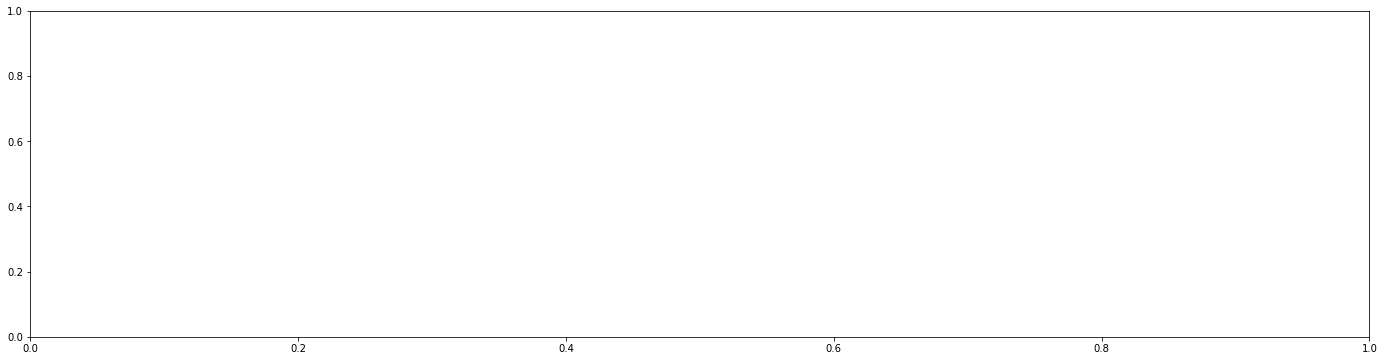

In [6]:
q = data[11]
times = data[6]
lc = data[8]
medLc = np.median(lc)
for i in range(len(lc)):
    if q[i] != 0:
        lc[i] = medLc

cutTimes, cutLc = cutLightCurve(times, lc, 1545, 1600)
midTime = np.percentile(cutTimes,25)
cutTimes = cutTimes - midTime

fig, ax = plt.subplots(1,1,figsize=(24,6))
ax.plot(cutTimes,cutLc,color="#1969ea",ls="-",lw=5)
plt.xlabel("Time",fontsize=14)
plt.ylabel("Flux",fontsize=14)
plt.title(r"TESS 612256219 Light Curve",fontsize=16)
plt.show()

In [36]:
dif = []
for i in range(len(times)):
    if i != 0:
        dif.append(times[i] - times[i-1])
print(max(dif),min(dif))

1.2083458706836154 0.020833488317975934


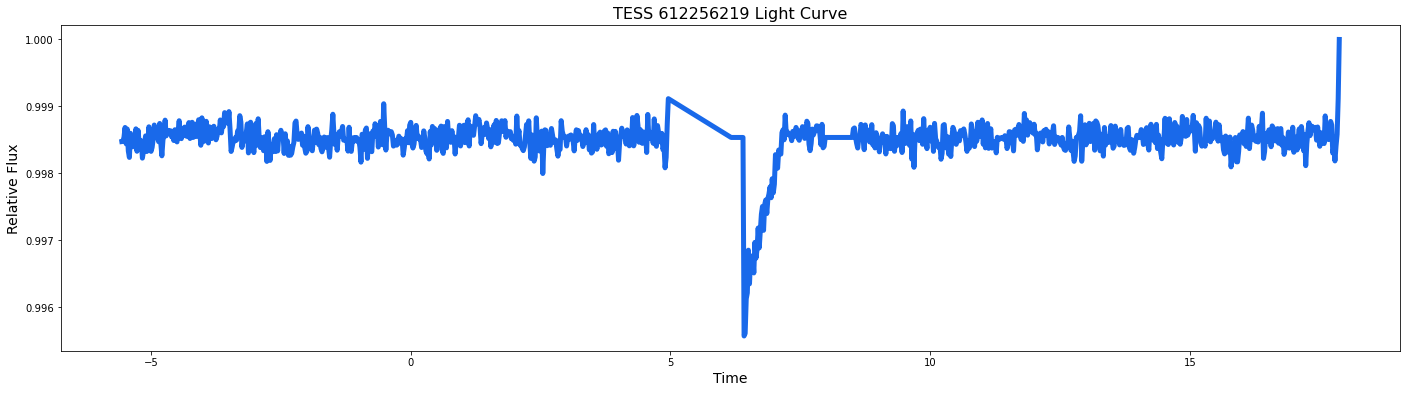

In [18]:
maxlc = max(cutLc)
normLc = cutLc/maxlc

fig, ax = plt.subplots(1,1,figsize=(24,6))
ax.plot(cutTimes,normLc,color="#1969ea",ls="-",lw=5)
plt.xlabel("Time",fontsize=14)
plt.ylabel("Relative Flux",fontsize=14)
plt.title(r"TESS 612256219 Light Curve",fontsize=16)
plt.show()

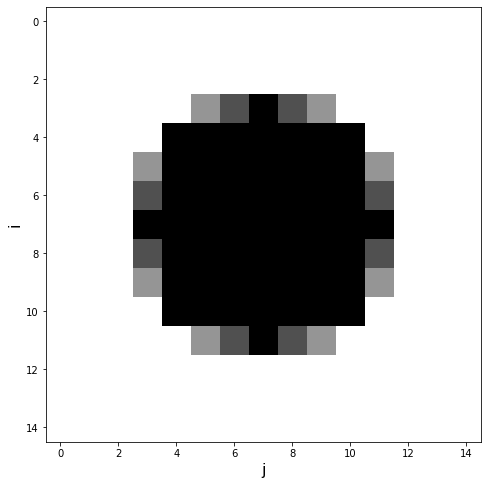

In [19]:
times = np.linspace(-10.0,10.0,500)

planetGrid = np.zeros((30,30))
planetGrid[6:24,13:17] = 1
planetGrid[13:17,6:24] = 1
planetGrid[7:23,10:20] = 1
planetGrid[10:20,7:23] = 1
planetGrid[8:22,8:22] = 1
planetGrid[9:21,9:21] = 1


planet = TransitingImage(opacitymat = planetGrid, lowres = 15, lowrestype="mean",lowresround = False, v = 1, t_ref = 0, t_arr = cutTimes)

planet.plot_grid()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


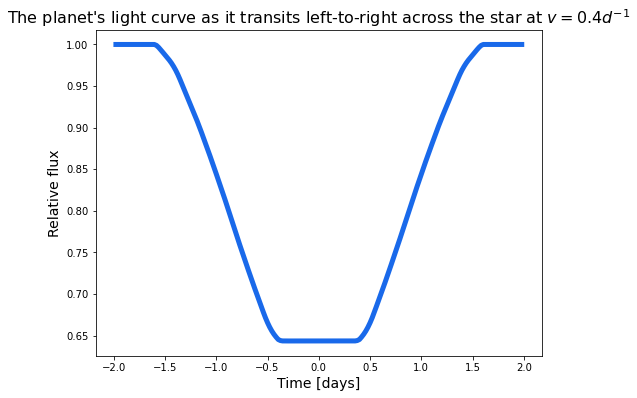

In [20]:
planetLC, overlapTimes = planet.gen_LC(t_arr = cutTimes)

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(overlapTimes,planetLC,color="#1969ea",ls="-",lw=5)
plt.xlabel("Time [days]",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"The planet's light curve as it transits left-to-right across the star at $v = 0.4 d^{-1}$",fontsize=16)
plt.show()

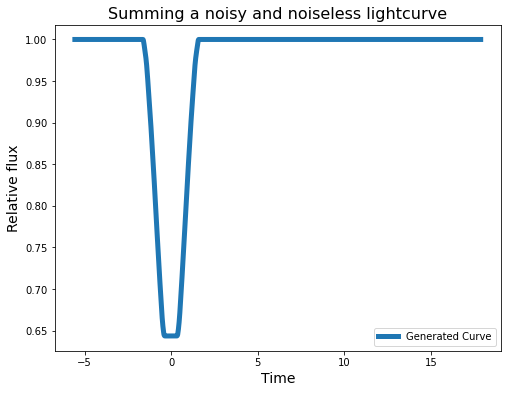

In [21]:
longTransitLC, times = ebtExtendLC(planetLC, overlapTimes, cutTimes)
sumLC = ebtSumLightCurves(normLc, longTransitLC)

fig, ax = plt.subplots(1,1,figsize=(8,6))
#ax.plot(times,sumLC,ls="-",lw=5, label = "Summed Curve")
#ax.plot(times,normLc,ls='-',lw = 5, label = "Observed Curve", zorder = -1)
ax.plot(times,longTransitLC,ls='-',lw=5,label = "Generated Curve", zorder = -2)
ax.legend()
plt.xlabel("Time",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"Summing a noisy and noiseless lightcurve",fontsize=16)
plt.show()